In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
import pandas as pd

import dgl
import numpy as np
import torch as th
from dgl.nn import EdgeGATConv

%matplotlib inline

#torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [2]:
# df1=pd.read_csv('./dataset/ogbn_proteins/raw/edge.csv.gz')
# df2=pd.read_csv('./dataset/ogbn_proteins/raw/node_species.csv.gz')
# df3=pd.read_csv('./dataset/ogbn_proteins/raw/node-label-modified.csv.gz')
# df4=pd.read_csv('./dataset/ogbn_proteins/raw/edge-feat.csv.gz')

In [3]:
# graph = dgl.graph((df1['1'], df1['96401']))

In [4]:
# graph.ndata['feature']=torch.tensor(df3.iloc[:,:].values)
# graph.edata['feature']=torch.tensor(df4.iloc[:,:].values)

In [5]:
# import pickle

# with open('graph.pkl', 'wb') as file:
#     pickle.dump(graph, file)


In [6]:
import pickle
with open('graph.pkl', 'rb') as file:
    graph = pickle.load(file)

In [7]:
import networkx as nx
G=dgl.to_networkx(graph)
# A=nx.to_scipy_sparse_matrix(G, format='csr')
# A

In [8]:
with open('A.pkl', 'rb') as file:
    A = pickle.load(file)

In [9]:
# Load the CSV file into a DataFrame
df = pd.read_csv('./dataset/ogbn_proteins/raw/node_species.csv.gz', header=None, names=['species_id'])

# Reset index to make node id a column
df.reset_index(inplace=True)

# Create binary columns for each species using get_dummies
affiliation_matrix = pd.get_dummies(df, columns=['species_id'], prefix='', prefix_sep='').groupby('index').max()

In [10]:
Z_gt=affiliation_matrix.astype('int').values
# orG = G
N, K = Z_gt.shape

In [33]:
in_feats=112
edge_feats=8
out_feats=8
num_heads=1
feat_drop=0.5
attn_drop=0.5
negative_slope=0.2
residual=True
activation=F.relu
allow_zero_in_degree=True
bias=False
hidden_feats = [64]

In [34]:
hidden_sizes = [64]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 5000        # number of epochs to train
display_step = 5       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 200000     # batch size (only for stochastic training)

In [35]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.EGCN(in_feats,
        edge_feats,
        hidden_sizes,
        out_feats,
        num_heads,
        feat_drop,
        attn_drop,
        negative_slope,
        residual,
        activation,
        allow_zero_in_degree,
        bias,
        dropout, 
        batch_norm)
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [36]:
gnn

EGCN(
  (edge_gat_conv): EdgeGATConv(
    (fc): Linear(in_features=112, out_features=64, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (res_fc): Linear(in_features=112, out_features=64, bias=False)
    (fc_edge): Linear(in_features=8, out_features=64, bias=False)
  )
  (gat_conv): GATConv(
    (fc): Linear(in_features=64, out_features=8, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
)

In [37]:
graph.ndata['feature']=graph.ndata['feature'].to(torch.float32)
graph.edata['feature']=graph.edata['feature'].to(torch.float32)

In [38]:
node_feats=graph.ndata['feature']
edge_feats=graph.edata['feature']

In [39]:
node_feats=F.normalize(node_feats)
edge_feats=F.normalize(edge_feats)

In [40]:
def get_nmi(thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    gnn.eval()
    Z = F.relu(gnn(graph, node_feats, edge_feats))
    Z=Z.reshape(Z.shape[0],Z.shape[3])
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

In [19]:
# Z = F.relu(gnn(graph, node_feats, edge_feats))
# Z.shape

In [20]:
# for epoch, batch in enumerate(sampler):
#     print()

In [41]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(graph, node_feats, edge_feats))
            Z=Z.reshape(Z.shape[0],Z.shape[3])
            val_loss = decoder.loss_full(Z, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.4f}')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(graph, node_feats, edge_feats))
    Z=Z.reshape(Z.shape[0],Z.shape[3])
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

Epoch    0, loss.full = 0.9356, nmi = 0.0545


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 10127680256 bytes.

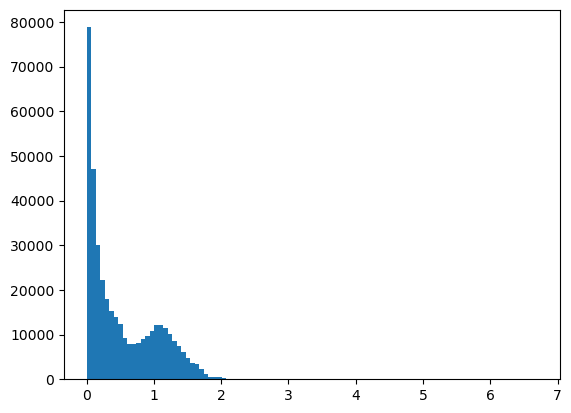

In [22]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

In [23]:
thresh = 0.5

Z = F.relu(gnn(graph, node_feats, edge_feats))
Z=Z.reshape(Z.shape[0],Z.shape[3])
Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
print(f'Final nmi = {get_nmi(thresh):.3f}')

Final nmi = 0.405


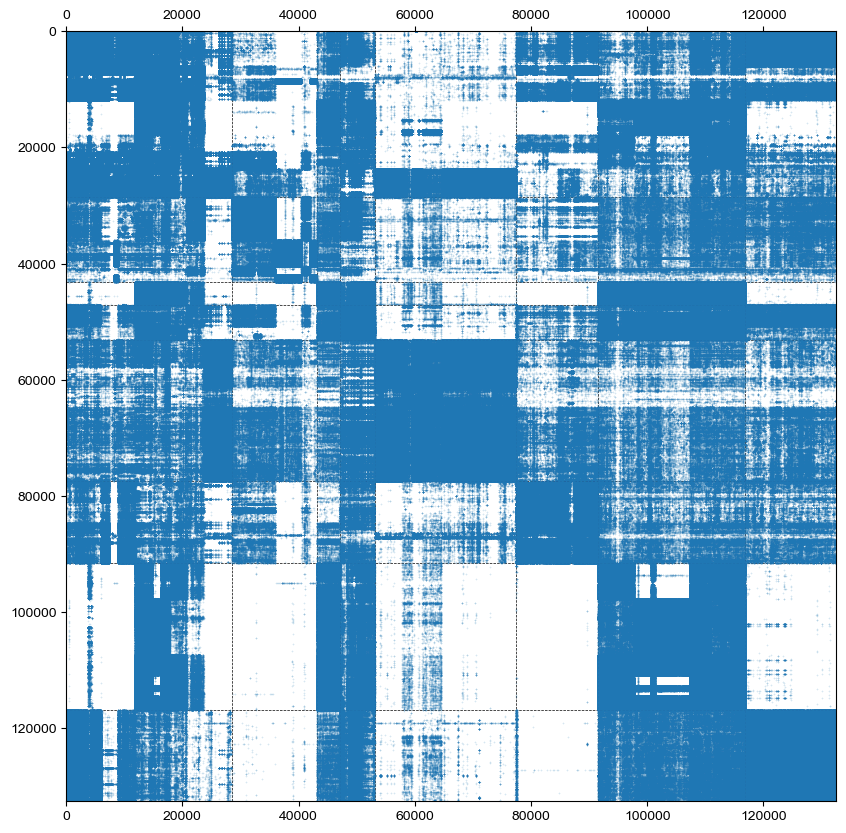

In [24]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.05)

In [25]:
# Sizes of detected communities
print(Z_pred.sum(0))

[22090 15704  5100  7056 28917 18621 34722 22390]


In [26]:
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

d:\Muttakin\nocd-modified\nocd\metrics\unsupervised.py:29: RuntimeWarning: overflow encountered in scalar multiply
  possible = (n - 2) * (n - 1) * n / 6


Ground truth communities:
 - coverage    = 0.8060
 - conductance = 0.1570
 - density     = 1.303e-02
 - clust_coef  = 0.000e+00


In [27]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.9075
 - conductance = 0.2044
 - density     = 1.212e-02
 - clust_coef  = 0.000e+00


In [28]:
Z_gt

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
Z_pred

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False]])

In [30]:
def get_comlist(community_matrix):
    transposed_matrix = np.transpose(community_matrix)

    # Initialize an empty list to store tuples (community_id, nodes_list)
    community_nodes_list = []

    # Iterate through rows (communities)
    for community_id, community_row in enumerate(transposed_matrix):
        # Find nodes (columns) where the value is 1
        community_nodes = np.where(community_row == 1)[0].tolist()
        
        # Append a tuple to the list containing community ID and nodes list
        community_nodes_list.append(community_nodes)
    
    return community_nodes_list

In [31]:
from cdlib import algorithms

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'leidenalg', 'infomap', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


In [32]:
from cdlib import NodeClustering
from cdlib import evaluation

coms1=get_comlist(Z_gt)
coms2=get_comlist(Z_pred)

communities1=NodeClustering(coms1,G)
communities2=NodeClustering(coms2,G)

onmi=evaluation.overlapping_normalized_mutual_information_LFK(communities1,communities2)
print(onmi)

MatchingResult(score=0.3877592683496218, std=None)
